# Unsupervised Learning and Dimensionality Reduction

Things to do:
 - Rerun the Neural Network on the Adult Data using all samples and a scaler
 - Run k-means and EM algorithms on the scaled Adult Data. Describe what you see
 - Run PCA, ICA, and Randomized Projects on the scaled adult data. Describe what you see.
 - Rerun k-means and EM on the data after it has been run through each dimensionality reduction algorithm
 - Rerun Neural Network on dimensionality reduced Adult Data
 - Rerun Neural Network on clustered data (use clusters as features)

# Load in Adult Data and Preprocess

In [30]:
%matplotlib inline

import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
train = pd.read_csv('adult_train.csv')
test = pd.read_csv('adult_test.csv')
test["income"] = test.income.apply(lambda x: x[:-1])
adult_data = pd.concat([train, test])

In [3]:
categorical_columns = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "sex", "native_country", "income"]

adult_data = pd.get_dummies(adult_data, columns=categorical_columns)

48842

In [4]:
y = adult_data["income_ >50K"]
X = adult_data.drop(["income_ >50K", "income_ <=50K"], axis=1)
X_columns = X.columns

In [5]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

# Run on a Neural Net

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier())
])

parameters = {
    'nn__hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

names = grid_search.cv_results_['param_nn__hidden_layer_sizes']
scores = grid_search.cv_results_['mean_test_score']

for name, score in zip(names, scores):
    print(f'{name}:\t\t\t {score}')

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier())
])

parameters = {
    'nn__hidden_layer_sizes' : [tuple([x]) for x in range(1, 20)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

names = grid_search.cv_results_['param_nn__hidden_layer_sizes']
scores = grid_search.cv_results_['mean_test_score']

for name, score in zip(names, scores):
    print(f'{name}:\t\t\t {score}')

I performed a grid search on the standardized data, first testing one to five hidden layers of 10 to 100 nodes each. The search found that a single layer of 10 was the optimum, but only by a small amount. The second grid search tested a single hidden layer with one to twenty nodes. Above 3 nodes, all cross validation scores were within a fraction of a percent of each other. All neural nets in this experiment moving forward used a single hidden layer of 5 nodes.

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", MLPClassifier(hidden_layer_sizes=(5)))
])

cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10).mean()

# Analysis Through K-Means

In [27]:
cluster_error = pd.DataFrame(columns=["k", "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans())
])

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    kmeans_pipeline = kmeans_pipeline.set_params(kmeans__n_clusters=k).fit(X_train)
    labels = kmeans_pipeline.named_steps["kmeans"].labels_
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "avg_inertia": kmeans_pipeline.named_steps["kmeans"].inertia_/len(X_train),
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    cluster_error = cluster_error.append(scores, ignore_index=True)
    
cluster_error

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


,k,time,avg_inertia,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,silhouette
0,2.0,2.618056,104.139930,0.150462,0.122435,0.135009,0.182152,0.122420,0.005061
1,5.0,5.221769,100.300651,0.180774,0.073498,0.104507,0.067210,0.073467,-0.374623
2,10.0,6.911834,93.732371,0.148681,0.049636,0.074425,0.030456,0.049576,-0.307914
3,15.0,7.660832,88.873704,0.231082,0.065428,0.101981,0.027863,0.065350,-0.503751
4,20.0,10.554778,83.906277,0.235408,0.066282,0.103439,0.013919,0.066177,-0.618706
5,25.0,11.189921,78.805294,0.249960,0.062644,0.100181,0.047341,0.062525,-0.552672
6,30.0,13.939255,74.854113,0.255079,0.055412,0.091046,0.029137,0.055287,-0.680567
7,40.0,13.345018,65.102013,0.225710,0.047367,0.078302,0.014416,0.047202,-0.656922
8,50.0,15.176386,54.792578,0.242442,0.048190,0.080399,0.029622,0.047994,-0.816197
9,100.0,27.924137,29.570970,0.240624,0.032279,0.056922,0.005157,0.032010,-0.840095


# Analysis Through EM

In [26]:
em_error = pd.DataFrame(columns=["k", "time", "lower_bound",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("em", GaussianMixture())
])

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    em_pipeline = em_pipeline.set_params(em__n_components=k).fit(X_train)
    labels = em_pipeline.predict(X_train)
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "lower_bound": em_pipeline.named_steps["em"].lower_bound_,
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "BIC" : em_pipeline.named_steps["em"].bic(X_train),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    em_error = em_error.append(scores, ignore_index=True)
    
em_error

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


,k,time,lower_bound,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,BIC,silhouette
0,2.0,2.321207,-37.773169,0.148576,0.121183,0.133489,0.183417,0.121168,2.178657e+15,-0.005449
1,5.0,12.781587,113.602096,0.062217,0.035236,0.044992,-0.048388,0.035191,1.885316e+15,-0.338519
2,10.0,20.318177,266.542330,0.189490,0.059413,0.090462,0.042725,0.059358,2.096757e+15,-0.441084
3,15.0,65.593852,192.875621,0.205838,0.056682,0.088887,0.021288,0.056606,2.025957e+15,-0.236980
4,20.0,63.534689,283.301600,0.211485,0.055093,0.087414,0.025204,0.054995,2.040378e+15,-0.578277
5,25.0,72.785139,219.942203,0.216853,0.049962,0.081213,0.049624,0.049852,2.097532e+15,-0.682518
6,30.0,89.579695,284.776617,0.197184,0.043446,0.071204,0.041886,0.043318,1.901434e+15,-0.712077
7,40.0,96.065422,346.416483,0.169144,0.033442,0.055844,0.006273,0.033286,1.979016e+15,-0.741955
8,50.0,176.163836,348.992854,0.204603,0.039333,0.065982,0.007030,0.039143,1.563459e+15,-0.828179
9,100.0,193.390495,468.569299,0.238202,0.031844,0.056178,0.005449,0.031576,1.275383e+15,-0.838437


# t-SNE Graph

In [104]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=250)
t0 = timeit.default_timer()
X_tsne = tsne.fit_transform(X_train)
tsne_time = timeit.default_timer() - t0

KeyboardInterrupt: 

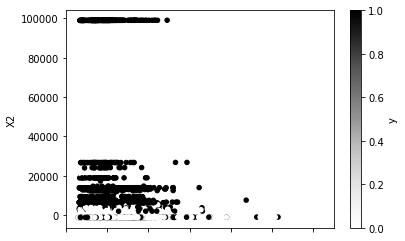

In [62]:
# X_tsne = pd.DataFrame(X_tsne, columns=["X1", "X2"])
X_tsne = X_tsne.assign(y = np.array(y_train))
X_tsne.plot.scatter(x='X1', y='X2', c="y")

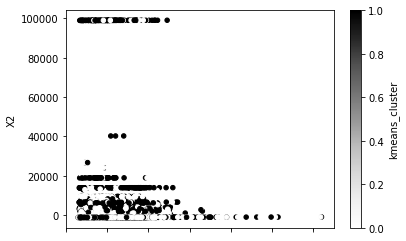

In [53]:
kmeans = kmeans_pipeline.set_params(kmeans__n_clusters=2).fit(X_train)
kmeans_labels = kmeans.named_steps["kmeans"].labels_
X_tsne = X_tsne.assign(kmeans_cluster = kmeans_labels)
X_tsne.plot.scatter(x='X1', y='X2', c="kmeans_cluster")

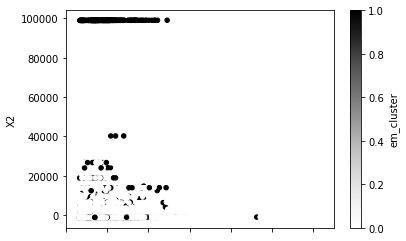

In [55]:
em = em_pipeline.set_params(em__n_components=2).fit(X_train)
em_labels = em_pipeline.predict(X_train)
X_tsne = X_tsne.assign(em_cluster = em_labels)
X_tsne.to_csv("tsne_without_transformation.csv")
X_tsne.plot.scatter(x='X1', y='X2', c="em_cluster")

# Principal Component Analysis

In [101]:
pca = PCA(random_state=231).fit(X_train)
pd.DataFrame(pca.explained_variance_).to_csv("pca_explained_variance.csv")

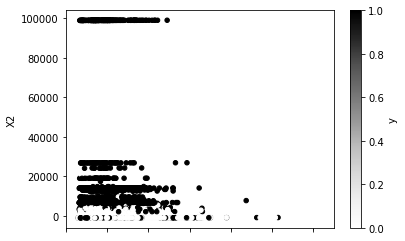

In [105]:
pca_2 = pd.DataFrame(pca.transform(X_train)[:,0:2], columns=["X1","X2"]).assign(y = np.array(y_train))
pca_2.plot.scatter(x='X1', y='X2', c='y')